# Wasserstein GAN

## Importing Libraries

In [1]:
!pip install -q pytorch-fid

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tqdm
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torchvision.utils
from pytorch_fid import fid_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting up the GPU

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Preprocessing the Images

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Loading the Dataset

In [5]:
batch_size = 128

In [6]:
dataset = datasets.MNIST(root='./data/train', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 172174690.63it/s]

Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 52576256.00it/s]


Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49224827.73it/s]

Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7580791.39it/s]


Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



## Generator Network

In [7]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=64):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 64*7*7), 
            nn.BatchNorm1d(64*7*7),
            nn.ReLU(),

            Reshape((-1, 16*4, 7, 7)),  # Reshape to be used in PixelShuffle
            nn.PixelShuffle(upscale_factor=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.PixelShuffle(upscale_factor=2),

            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        return z

## Critic Network

In [9]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.model(x)

## WGAN Loss

In [10]:
class WGANLosses:
    def critic_loss(self, outputs_real, outputs_fake):
        return -(torch.mean(outputs_real) - torch.mean(outputs_fake))

    def generator_loss(self, outputs):
        return -torch.mean(outputs)

### Noise Generation from Normal Distribution

In [11]:
def generate_noise(batch_size, latent_dim=64):
    return torch.randn(batch_size, latent_dim).to(device)

### Initialize Models and Loss

In [12]:
generator = Generator().to(device)
critic = Critic().to(device)
print(generator)
print(critic)

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=3136, bias=True)
    (4): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Reshape()
    (7): PixelShuffle(upscale_factor=2)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): PixelShuffle(upscale_factor=2)
    (12): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)
Critic(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-

In [13]:
wgan_losses = WGANLosses()

### Set Loss and Optimizer

In [14]:
# Set up the hyperparameters based on the paper
lr = 0.00005
beta1 = 0.5
beta2 = 0.9
clip_value = 0.01
batch_size = 64
ncritic = 5

In [15]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))

## Training the Model

In [16]:
def plot_losses(losses_G, losses_C):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_C, label='Critic Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
def plot_generated_images(generator, epoch, epochs):
    with torch.no_grad():
        fake_images = generator(generate_noise(100)).detach().cpu()
    fake_images = fake_images.view(-1, 1, 28, 28)
    vutils.save_image(fake_images, f"gan_samples_epoch_{epoch}.png" ,nrow=10, normalize=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(vutils.make_grid(fake_images, nrow=10, normalize=True).permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Generated Images From Epoch {epoch + 1} / {epochs}")
    plt.show()

In [18]:
num_epochs = 76

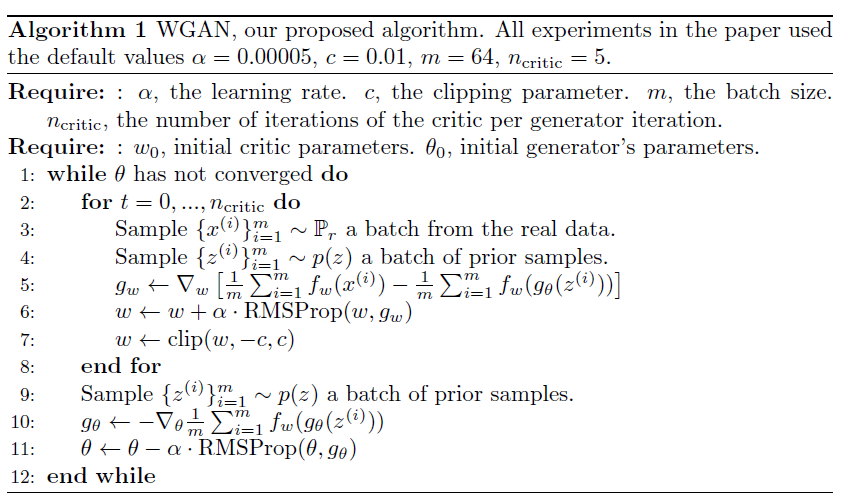

  0%|          | 0/76 [00:00<?, ?it/s]

Epoch [1/76], C Loss: -5.504610538482666, G Loss: -7.600829124450684


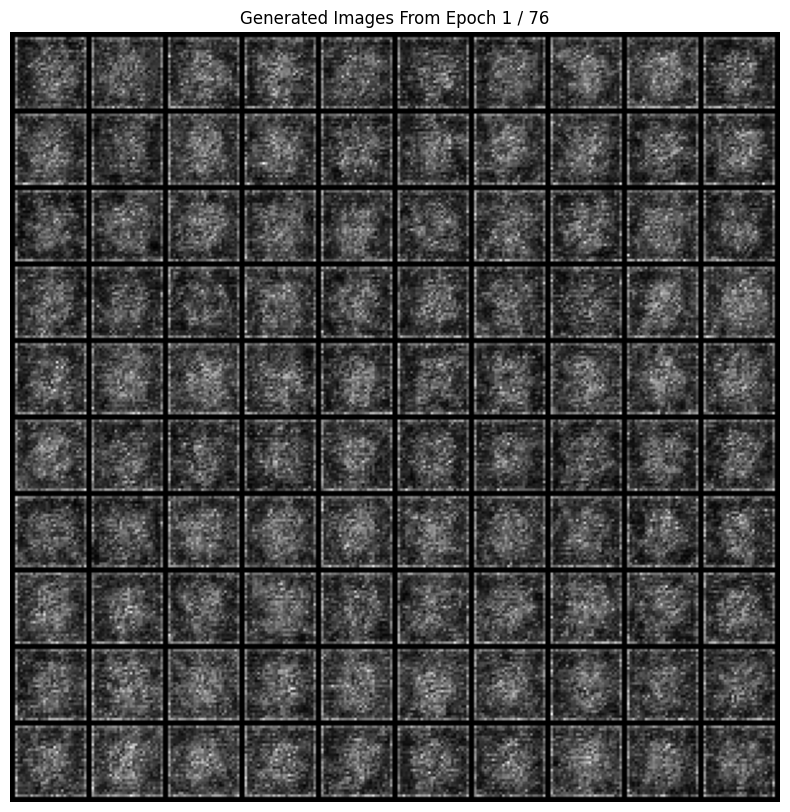

  3%|▎         | 2/76 [00:35<21:49, 17.70s/it]

Epoch [2/76], C Loss: -1.5131330490112305, G Loss: -10.876554489135742


  4%|▍         | 3/76 [00:52<20:59, 17.26s/it]

Epoch [3/76], C Loss: -2.0639901161193848, G Loss: 0.4735463857650757


  5%|▌         | 4/76 [01:09<20:39, 17.22s/it]

Epoch [4/76], C Loss: -1.3355369567871094, G Loss: -4.2402143478393555


  7%|▋         | 5/76 [01:26<20:16, 17.14s/it]

Epoch [5/76], C Loss: -0.45812106132507324, G Loss: -2.718836545944214


  8%|▊         | 6/76 [01:43<20:06, 17.23s/it]

Epoch [6/76], C Loss: -0.20916199684143066, G Loss: -1.6992213726043701


  9%|▉         | 7/76 [02:01<19:48, 17.23s/it]

Epoch [7/76], C Loss: -0.09924793243408203, G Loss: -1.5298969745635986


 11%|█         | 8/76 [02:18<19:30, 17.22s/it]

Epoch [8/76], C Loss: -0.07341164350509644, G Loss: 0.6634607315063477


 12%|█▏        | 9/76 [02:35<19:08, 17.15s/it]

Epoch [9/76], C Loss: -0.0528789758682251, G Loss: 1.0759769678115845


 13%|█▎        | 10/76 [02:52<18:52, 17.16s/it]

Epoch [10/76], C Loss: -0.08569943904876709, G Loss: 1.4767478704452515


 14%|█▍        | 11/76 [03:09<18:35, 17.16s/it]

Epoch [11/76], C Loss: -0.039899349212646484, G Loss: 1.2405402660369873


 16%|█▌        | 12/76 [03:26<18:17, 17.14s/it]

Epoch [12/76], C Loss: -0.06636333465576172, G Loss: 1.7469977140426636


 17%|█▋        | 13/76 [03:44<18:05, 17.22s/it]

Epoch [13/76], C Loss: -0.021231651306152344, G Loss: 1.1862789392471313


 18%|█▊        | 14/76 [04:01<17:44, 17.16s/it]

Epoch [14/76], C Loss: -0.07353508472442627, G Loss: 1.9177837371826172


 20%|█▉        | 15/76 [04:18<17:29, 17.21s/it]

Epoch [15/76], C Loss: -0.03583759069442749, G Loss: 0.8253251910209656


 21%|██        | 16/76 [04:35<17:09, 17.16s/it]

Epoch [16/76], C Loss: -0.0266207754611969, G Loss: -0.39621490240097046


 22%|██▏       | 17/76 [04:52<16:54, 17.19s/it]

Epoch [17/76], C Loss: -0.0747905969619751, G Loss: 2.0438342094421387


 24%|██▎       | 18/76 [05:10<16:36, 17.18s/it]

Epoch [18/76], C Loss: -0.011515974998474121, G Loss: 0.42893099784851074


 25%|██▌       | 19/76 [05:27<16:24, 17.27s/it]

Epoch [19/76], C Loss: 0.011332511901855469, G Loss: 1.2509733438491821


 26%|██▋       | 20/76 [05:44<16:04, 17.23s/it]

Epoch [20/76], C Loss: -0.04835402965545654, G Loss: 1.1893303394317627


 28%|██▊       | 21/76 [06:01<15:48, 17.24s/it]

Epoch [21/76], C Loss: -0.04329082369804382, G Loss: 0.6679215431213379


 29%|██▉       | 22/76 [06:19<15:29, 17.21s/it]

Epoch [22/76], C Loss: -0.02790045738220215, G Loss: -2.2637524604797363


 30%|███       | 23/76 [06:36<15:12, 17.22s/it]

Epoch [23/76], C Loss: -0.004027605056762695, G Loss: -2.6490285396575928


 32%|███▏      | 24/76 [06:53<14:53, 17.19s/it]

Epoch [24/76], C Loss: -0.042690277099609375, G Loss: -2.082253932952881


 33%|███▎      | 25/76 [07:10<14:32, 17.11s/it]

Epoch [25/76], C Loss: -0.04712390899658203, G Loss: 1.9363822937011719


 34%|███▍      | 26/76 [07:27<14:17, 17.15s/it]

Epoch [26/76], C Loss: -0.015725135803222656, G Loss: -0.8325554132461548


 36%|███▌      | 27/76 [07:44<14:03, 17.22s/it]

Epoch [27/76], C Loss: -0.053011417388916016, G Loss: -2.327108383178711


 37%|███▋      | 28/76 [08:02<13:43, 17.16s/it]

Epoch [28/76], C Loss: -0.05292999744415283, G Loss: 0.8161875009536743


 38%|███▊      | 29/76 [08:19<13:28, 17.20s/it]

Epoch [29/76], C Loss: -0.04011642932891846, G Loss: -0.28117015957832336


 39%|███▉      | 30/76 [08:36<13:12, 17.23s/it]

Epoch [30/76], C Loss: -0.0381929874420166, G Loss: 0.609742283821106


 41%|████      | 31/76 [08:53<12:50, 17.12s/it]

Epoch [31/76], C Loss: -0.027656108140945435, G Loss: -0.010446283034980297


 42%|████▏     | 32/76 [09:10<12:34, 17.14s/it]

Epoch [32/76], C Loss: 0.015158414840698242, G Loss: 1.3846420049667358


 43%|████▎     | 33/76 [09:27<12:14, 17.08s/it]

Epoch [33/76], C Loss: -0.03193259239196777, G Loss: -1.0984772443771362


 45%|████▍     | 34/76 [09:44<11:57, 17.09s/it]

Epoch [34/76], C Loss: -0.02774602174758911, G Loss: 1.0440634489059448


 46%|████▌     | 35/76 [10:01<11:39, 17.07s/it]

Epoch [35/76], C Loss: 0.010873794555664062, G Loss: 0.34312641620635986


 47%|████▋     | 36/76 [10:18<11:23, 17.09s/it]

Epoch [36/76], C Loss: -0.031032085418701172, G Loss: 1.2505409717559814


 49%|████▊     | 37/76 [10:35<11:04, 17.05s/it]

Epoch [37/76], C Loss: -0.040062904357910156, G Loss: 1.7380203008651733


 50%|█████     | 38/76 [10:52<10:46, 17.03s/it]

Epoch [38/76], C Loss: 0.0678856372833252, G Loss: 1.117682695388794
Epoch [39/76], C Loss: -0.006621241569519043, G Loss: -0.9493513107299805


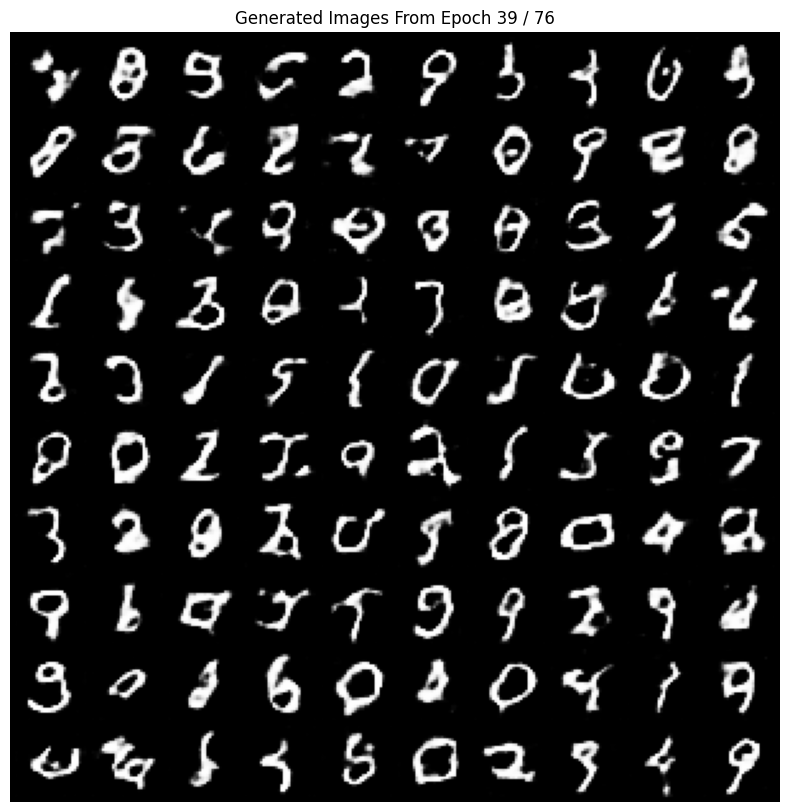

 53%|█████▎    | 40/76 [11:27<10:14, 17.07s/it]

Epoch [40/76], C Loss: -0.00897112488746643, G Loss: 0.4090856909751892


 54%|█████▍    | 41/76 [11:43<09:55, 17.02s/it]

Epoch [41/76], C Loss: -0.023328036069869995, G Loss: -0.2176198810338974


 55%|█████▌    | 42/76 [12:01<09:39, 17.05s/it]

Epoch [42/76], C Loss: 0.012826323509216309, G Loss: 0.6373147964477539


 57%|█████▋    | 43/76 [12:17<09:20, 16.98s/it]

Epoch [43/76], C Loss: -0.041414856910705566, G Loss: -1.2990882396697998


 58%|█████▊    | 44/76 [12:35<09:04, 17.01s/it]

Epoch [44/76], C Loss: -0.03691476583480835, G Loss: -0.37142765522003174


 59%|█████▉    | 45/76 [12:52<08:47, 17.01s/it]

Epoch [45/76], C Loss: -0.02552926540374756, G Loss: 1.7158435583114624


 61%|██████    | 46/76 [13:08<08:25, 16.85s/it]

Epoch [46/76], C Loss: -0.05703568458557129, G Loss: 2.052654981613159


 62%|██████▏   | 47/76 [13:25<08:08, 16.86s/it]

Epoch [47/76], C Loss: -0.04072105884552002, G Loss: 0.9796855449676514


 63%|██████▎   | 48/76 [13:42<07:52, 16.86s/it]

Epoch [48/76], C Loss: -0.016219377517700195, G Loss: 1.9274144172668457


 64%|██████▍   | 49/76 [13:58<07:32, 16.76s/it]

Epoch [49/76], C Loss: -0.049741148948669434, G Loss: 2.1033761501312256


 66%|██████▌   | 50/76 [14:15<07:15, 16.74s/it]

Epoch [50/76], C Loss: -0.08368182182312012, G Loss: -2.447834014892578


 67%|██████▋   | 51/76 [14:32<06:58, 16.74s/it]

Epoch [51/76], C Loss: -0.012737512588500977, G Loss: 0.4583762586116791


 68%|██████▊   | 52/76 [14:48<06:40, 16.67s/it]

Epoch [52/76], C Loss: -0.024780750274658203, G Loss: 0.6869799494743347


 70%|██████▉   | 53/76 [15:05<06:24, 16.70s/it]

Epoch [53/76], C Loss: 0.006013393402099609, G Loss: 0.8232415914535522


 71%|███████   | 54/76 [15:22<06:07, 16.70s/it]

Epoch [54/76], C Loss: -0.027510225772857666, G Loss: 0.7248972654342651


 72%|███████▏  | 55/76 [15:38<05:49, 16.66s/it]

Epoch [55/76], C Loss: -0.04021739959716797, G Loss: -0.666041374206543


 74%|███████▎  | 56/76 [15:55<05:33, 16.68s/it]

Epoch [56/76], C Loss: -0.05226707458496094, G Loss: 1.657758116722107


 75%|███████▌  | 57/76 [16:11<05:15, 16.63s/it]

Epoch [57/76], C Loss: 0.05773568153381348, G Loss: 2.481919765472412


 76%|███████▋  | 58/76 [16:28<05:00, 16.68s/it]

Epoch [58/76], C Loss: -0.04765719175338745, G Loss: 1.0101608037948608


 78%|███████▊  | 59/76 [16:45<04:44, 16.72s/it]

Epoch [59/76], C Loss: -0.02518308162689209, G Loss: -0.8318334817886353


 79%|███████▉  | 60/76 [17:02<04:28, 16.76s/it]

Epoch [60/76], C Loss: -0.0011653900146484375, G Loss: -2.57851505279541


 80%|████████  | 61/76 [17:18<04:10, 16.70s/it]

Epoch [61/76], C Loss: -0.01175554096698761, G Loss: 0.006305370479822159


 82%|████████▏ | 62/76 [17:35<03:53, 16.67s/it]

Epoch [62/76], C Loss: -0.022451281547546387, G Loss: -1.5110290050506592


 83%|████████▎ | 63/76 [17:52<03:36, 16.68s/it]

Epoch [63/76], C Loss: -0.021515727043151855, G Loss: 0.05320762097835541


 84%|████████▍ | 64/76 [18:08<03:19, 16.63s/it]

Epoch [64/76], C Loss: -0.027548372745513916, G Loss: -0.5335273146629333


 86%|████████▌ | 65/76 [18:25<03:02, 16.60s/it]

Epoch [65/76], C Loss: 0.006104707717895508, G Loss: 2.221863269805908


 87%|████████▋ | 66/76 [18:41<02:45, 16.60s/it]

Epoch [66/76], C Loss: -0.019217506051063538, G Loss: -0.052180349826812744


 88%|████████▊ | 67/76 [18:58<02:29, 16.63s/it]

Epoch [67/76], C Loss: -0.11366605758666992, G Loss: -2.368464708328247


 89%|████████▉ | 68/76 [19:15<02:13, 16.71s/it]

Epoch [68/76], C Loss: -0.015470564365386963, G Loss: 0.8162629008293152


 91%|█████████ | 69/76 [19:32<01:57, 16.72s/it]

Epoch [69/76], C Loss: -0.0228765606880188, G Loss: -0.8343113660812378


 92%|█████████▏| 70/76 [19:48<01:39, 16.66s/it]

Epoch [70/76], C Loss: -0.05431818962097168, G Loss: -1.9158227443695068


 93%|█████████▎| 71/76 [20:05<01:23, 16.70s/it]

Epoch [71/76], C Loss: -0.06029677391052246, G Loss: 1.6467695236206055


 95%|█████████▍| 72/76 [20:21<01:06, 16.60s/it]

Epoch [72/76], C Loss: -0.02115955948829651, G Loss: -0.3884822726249695


 96%|█████████▌| 73/76 [20:38<00:50, 16.72s/it]

Epoch [73/76], C Loss: -0.003810882568359375, G Loss: 0.940558910369873


 97%|█████████▋| 74/76 [20:55<00:33, 16.71s/it]

Epoch [74/76], C Loss: -0.05621767044067383, G Loss: -2.2057788372039795


 99%|█████████▊| 75/76 [21:12<00:16, 16.81s/it]

Epoch [75/76], C Loss: 0.012012720108032227, G Loss: -1.351353645324707


100%|██████████| 76/76 [21:29<00:00, 16.97s/it]

Epoch [76/76], C Loss: -0.03223466873168945, G Loss: -1.5971479415893555


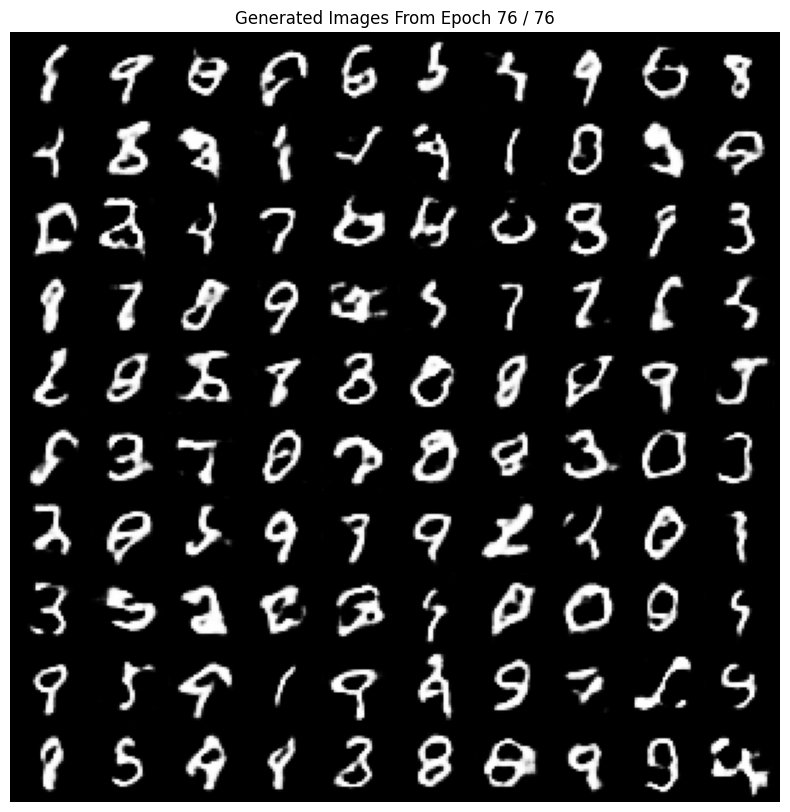

In [19]:
losses_G = []
losses_C = []

for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        size = real_images.shape[0]
        # Update the critic n times
        for _ in range(ncritic):
            real_images = real_images.to(device)
            optimizer_C.zero_grad()
            z = generate_noise(size)
            fake_images = generator(z)
            
            # Critic loss
            outputs_real = critic(real_images)
            outputs_fake = critic(fake_images.detach())
            loss_C = wgan_losses.critic_loss(outputs_real, outputs_fake)
            loss_C.backward()
            optimizer_C.step()

            # Clip critic weights
            # w  <- clip(w;􀀀c; c)
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Update the generator
        optimizer_G.zero_grad()
        z = generate_noise(size)
        fake_images = generator(z)
        
        # Generator loss
        outputs = critic(fake_images)
        loss_G = wgan_losses.generator_loss(outputs)
        loss_G.backward()
        optimizer_G.step()

    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}], C Loss: {loss_C.item()}, G Loss: {loss_G.item()}")

     # Save generated images at initial and medial intervals
    if epoch == num_epochs/2 or epoch == 0:
        plot_generated_images(generator, epoch, num_epochs)

# Save the final generated images
plot_generated_images(generator, epoch, num_epochs)

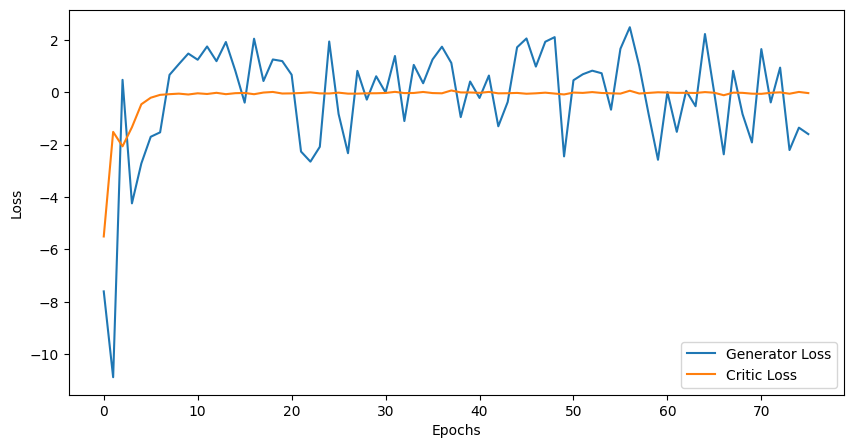

In [20]:
plot_losses(losses_G, losses_C)

## Evaluating the Model

###  Load the MNIST Test Dataset

In [21]:
batch_size = 64
mnist_test_dataset = datasets.MNIST(root="./data/test", train=False, download=True, transform=transform)
test_dataloader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 149825622.34it/s]

Extracting ./data/test/MNIST/raw/train-images-idx3-ubyte.gz to ./data/test/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44437158.41it/s]


Extracting ./data/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48215532.93it/s]


Extracting ./data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8852476.19it/s]

Extracting ./data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/test/MNIST/raw



#### Real Images

In [22]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
os.makedirs("real_images", exist_ok=True)
for i, (images, labels) in enumerate(test_dataloader):
    for j in range(images.size(0)):
        img = transform(images[j].squeeze())
        filename = f"{i * batch_size + j}.png"
        img_path = os.path.join("real_images", filename)
        torchvision.utils.save_image(img, img_path)

In [23]:
real_images_path = "real_images"

#### Fake Images

In [24]:
num_samples = len(test_dataloader.dataset)
os.makedirs("fake_images", exist_ok=True)
with torch.no_grad():
    for i in range(num_samples // batch_size):
        z = generate_noise(batch_size)
        fake_batch = generator(z)
        for j in range(fake_batch.size(0)):
            img = transform(fake_batch[j].squeeze())
            filename = f"{i * batch_size + j}.png"
            img_path = os.path.join("fake_images", filename)
            torchvision.utils.save_image(img, img_path)

In [25]:
fake_images_path = "fake_images" 

### Calculate Fréchet Inception Distance (FID) Score

In [26]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=batch_size, dims=2048, device=device)
print(f"FID Score: {fid_value}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 296MB/s]
100%|██████████| 156/156 [00:42<00:00,  3.69it/s]


FID Score: 37.977727046721895
